In [1]:
#importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, nltk

#import gensim
#import codecs
#from sner import Ner
import spacy
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#from nltk.internals import find_jars_within_path
#from nltk.tag import StanfordPOSTagger
#from nltk.tag import StanfordNERTagger

from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import fbeta_score, accuracy_score
from scipy.sparse import hstack

In [2]:
#function to load the dataset
def load(path: str) -> pd.DataFrame:
    rows = []

    with open(path, "r", encoding="latin-1") as data_in:
        for line in data_in:
            fine_category, input = line.split(None, 1)
            coarse_category, _ = fine_category.split(":")

            rows.append({
                "question": input.strip(),
                "fine_category": fine_category,
                "coarse_category": coarse_category
            })

    return pd.DataFrame(rows)

In [3]:
train = load('homework_research_scientist/data/train_5500.label.txt')
test = load('homework_research_scientist/data/test_TREC_10.label.txt')

In [4]:
train.head()

,question,fine_category,coarse_category
0,How did serfdom develop in and then leave Russ...,DESC:manner,DESC
1,What films featured the character Popeye Doyle ?,ENTY:cremat,ENTY
2,How can I find a list of celebrities ' real na...,DESC:manner,DESC
3,What fowl grabs the spotlight after the Chines...,ENTY:animal,ENTY
4,What is the full form of .com ?,ABBR:exp,ABBR


In [5]:
train.describe()

,question,fine_category,coarse_category
count,5452,5452,5452
unique,5381,50,6
top,How deep is a fathom ?,HUM:ind,ENTY
freq,3,962,1250


In [6]:
test.head()

,question,fine_category,coarse_category
0,How far is it from Denver to Aspen ?,NUM:dist,NUM
1,"What county is Modesto , California in ?",LOC:city,LOC
2,Who was Galileo ?,HUM:desc,HUM
3,What is an atom ?,DESC:def,DESC
4,When did Hawaii become a state ?,NUM:date,NUM


In [7]:
test.describe()

,question,fine_category,coarse_category
count,500,500,500
unique,500,42,6
top,What is the population of Seattle ?,DESC:def,DESC
freq,1,123,138


# Observations

- Train set contains 71 duplicates
- 50 unique fine_category classes in train and only 42 in test, a potential reason for low model performance.

In [8]:
#training encoders to encode out class labels
from sklearn.preprocessing import LabelEncoder
le_coarse = LabelEncoder()
le_coarse.fit(pd.Series(train.coarse_category.tolist() + test.coarse_category.tolist()).values)
train['coarse_category'] = le_coarse.transform(train.coarse_category.values)
test['coarse_category'] = le_coarse.transform(test.coarse_category.values)

le_fine = LabelEncoder()
le_fine.fit(pd.Series(train.fine_category.tolist() + test.fine_category.tolist()).values)
train['fine_category'] = le_fine.transform(train.fine_category.values)
test['fine_category'] = le_fine.transform(test.fine_category.values)

In [9]:
#corpus of all the data we have, train and test
def get_all_corpus(train:pd.DataFrame, test:pd.DataFrame, field_name: str):
    '''
    AIM: to get all the text data we have into a pandas object
    INPUT: training and test dataframes
    OUTPUT: pandas object containing all the text data 
    '''
    
    return pd.Series(train[field_name].tolist() + test[field_name].tolist()).astype(str)    

In [10]:
all_corpus = get_all_corpus(train, test, 'question')

In [11]:
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adityanannapaneni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adityanannapaneni/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
def text_clean(corpus, keep_list):
    '''
    AIM : Function to keep only alphabets, digits and certain words (punctuations, qmarks, tabs etc. removed)
    
    INPUT : Takes a text corpus, 'corpus' to be cleaned along with a list of words, 'keep_list', which have to be retained
            even after the cleaning process
    
    OUTPUT : Returns the cleaned text corpus
    
    '''
    cleaned_corpus = pd.Series()
    for row in corpus:
        qs = []
        for word in row.split():
            if word not in keep_list:
                p1 = re.sub(pattern='[^a-zA-Z0-9]',repl=' ',string=word)
                p1 = p1.lower()
                qs.append(p1)
            else : qs.append(word)
        cleaned_corpus = cleaned_corpus.append(pd.Series(' '.join(qs)))
    return cleaned_corpus

In [13]:
def preprocess(corpus, keep_list, cleaning = True, stemming = False, stem_type = None, lemmatization = False, remove_stopwords = True):
    
    '''
    AIM : Function to perform all pre-processing tasks (cleaning, stemming, lemmatization, stopwords removal etc.)
    
    Input : 
    'corpus' - Text corpus on which pre-processing tasks will be performed
    'keep_list' - List of words to be retained during cleaning process
    'cleaning', 'stemming', 'lemmatization', 'remove_stopwords' - Boolean variables indicating whether a particular task should 
                                                                  be performed or not
    'stem_type' - Choose between Porter stemmer or Snowball(Porter2) stemmer. Default is "None", which corresponds to Porter
                  Stemmer. 'snowball' corresponds to Snowball Stemmer
    
    Note : Either stemming or lemmatization should be used. There's no benefit of using both of them together
    
    Output : Returns the processed text corpus
    
    '''
    if cleaning == True:
        corpus = text_clean(corpus, keep_list)
    
    if remove_stopwords == True:
        wh_words = ['who', 'what', 'when', 'why', 'how', 'which', 'where', 'whom']
        stop = set(stopwords.words('english'))
        for word in wh_words:
            stop.remove(word)
        corpus = [[x for x in x.split() if x not in stop] for x in corpus]
    else :
        corpus = [[x for x in x.split()] for x in corpus]
    
    if lemmatization == True:
        lem = WordNetLemmatizer()
        corpus = [[lem.lemmatize(x, pos = 'v') for x in x] for x in corpus]
    
    if stemming == True:
        if stem_type == 'snowball':
            stemmer = SnowballStemmer(language = 'english')
            corpus = [[stemmer.stem(x) for x in x] for x in corpus]
        else :
            stemmer = PorterStemmer()
            corpus = [[stemmer.stem(x) for x in x] for x in corpus]
    
    corpus = [' '.join(x) for x in corpus]
        

    return corpus

In [14]:
common_dot_words = ['U.S.', 'St.', 'Mr.', 'Mrs.', 'D.C.']
all_corpus = preprocess(all_corpus, keep_list = common_dot_words, remove_stopwords = True)

/Users/adityanannapaneni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()


In [15]:
print(all_corpus[0])

how serfdom develop leave russia


# Splitting into train and test

In [16]:
train_corpus = all_corpus[0:train.shape[0]]
test_corpus = all_corpus[train.shape[0]:]

In [181]:
import en_core_web_sm
nlp = en_core_web_sm.load()

#nlp = spacy.load('en_core_web_sm')

In [18]:
#function to get ner, lemmas, POS tags, syntactic dependency relation and orthographic features
def get_nlp_features(data:list):
    '''
    AIM: to featurize the data and extract ner, pos tags, lemmas, dependencies, orthographic features
    INPUT: data to featurize 
    OUTPUT: lists containing the specified features
    '''
    ners = []
    lemmas = []
    tags = []
    deps = []
    shapes = []
    
    for row in data:
        doc = nlp(row)
        ner = []
        lemma = []
        tag = []
        dep = []
        shape = []
        
        for token in doc:
            lemma.append(token.lemma_)
            tag.append(token.tag_)
            dep.append(token.dep_)
            shape.append(token.shape_)
        lemmas.append(" ".join(lemma))
        tags.append(" ".join(tag))
        deps.append(" ".join(dep))
        shapes.append(" ".join(shape))
        
        for ent in doc.ents:
            ner.append(ent.label_)
        ners.append(" ".join(ner))
    return [ners, lemmas, tags, deps, shapes]    

In [19]:
train_features = get_nlp_features(train_corpus)

In [20]:
len(train_features[0])

5452

In [21]:
#converting the feeatures into vectors, could experiment with different ngram ranges

def train_vectorizers(features:list):
    '''
    AIM: trains Countvectorizers pertaining to the relavant feature
    INPUT: list of features to convert
    OUTPUT: vectors representing each of the features
    '''
    count_vec_ner = CountVectorizer(ngram_range=(1,2)).fit(features[0])
    count_vec_lemma = CountVectorizer(ngram_range=(1,2)).fit(features[1])
    count_vec_tags = CountVectorizer(ngram_range=(1,2)).fit(features[2])
    count_vec_deps = CountVectorizer(ngram_range=(1,2)).fit(features[3])
    count_vec_shapes = CountVectorizer(ngram_range=(1,2)).fit(features[4])
    
    return count_vec_ner, count_vec_lemma, count_vec_tags, count_vec_shapes

        

In [22]:
count_vec_ner, count_vec_lemma, count_vec_tags, count_vec_shapes = train_vectorizers(train_features)
count_vecs = [count_vec_ner, count_vec_lemma, count_vec_tags, count_vec_shapes]

In [23]:
def vectorize_features(count_vecs, features):
    '''
    AIM: transforms features into vectors by applying trained countvectorizers
    INPUT: list of countvectorizer and list of features
    OUTPUT: list of vectorized features
    '''
    vectorized_features = []
    for vec, feature in zip(count_vecs, features):
        vec_ft = vec.transform(feature)
        vectorized_features.append(vec_ft)
    return vectorized_features

In [24]:
training_features = vectorize_features(count_vecs, train_features)

In [25]:
training_features

[<5452x52 sparse matrix of type '<class 'numpy.int64'>'
 	with 1519 stored elements in Compressed Sparse Row format>,
 <5452x26732 sparse matrix of type '<class 'numpy.int64'>'
 	with 55872 stored elements in Compressed Sparse Row format>,
 <5452x461 sparse matrix of type '<class 'numpy.int64'>'
 	with 45029 stored elements in Compressed Sparse Row format>,
 <5452x81 sparse matrix of type '<class 'numpy.int64'>'
 	with 0 stored elements in Compressed Sparse Row format>]

In [26]:
#Converting from COOrdinate format to Compressed Sparse Row format for easier mathematical computations.

In [27]:
def wrangle_features(features):
    #combining all features into 1 matrix and into compresses sparse row format
    #for easier computations
    
    return hstack(features).tocsr()
    

In [28]:
training_features = wrangle_features(training_features)

In [29]:
training_features

<5452x27326 sparse matrix of type '<class 'numpy.int64'>'
	with 102420 stored elements in Compressed Sparse Row format>

In [30]:
# getting test features using the trained countvecs
test_features = get_nlp_features(test_corpus)
testing_features = vectorize_features(count_vecs, test_features)

In [31]:
testing_features = wrangle_features(testing_features)

In [32]:
testing_features

<500x27326 sparse matrix of type '<class 'numpy.int64'>'
	with 5272 stored elements in Compressed Sparse Row format>

In [33]:
# Model training
model_coarse = svm.LinearSVC()
model_fine = svm.LinearSVC()

In [34]:
model_coarse.fit(training_features, train['coarse_category'].values)
model_fine.fit(training_features, train['fine_category'])

LinearSVC()

In [35]:
# Model Evaluation
preds_coarse = model_coarse.predict(testing_features)
preds_fine = model_fine.predict(testing_features)

In [196]:
print(accuracy_score(test['coarse_category'].values, preds_coarse)*100)
print(accuracy_score(test['fine_category'].values, preds_fine)*100)

87.8
81.6


In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[  7   2   0   0   0   0]
 [  0 136   1   1   0   0]
 [  0  16  66   9   3   0]
 [  0   3   0  61   1   0]
 [  0   8   3   0  70   0]
 [  0  10   1   0   3  99]]


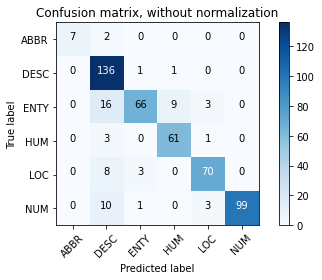

In [38]:
cnf_matrix = confusion_matrix(test['coarse_category'], preds_coarse)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(le_coarse.classes_),normalize=False,
                      title='Confusion matrix, without normalization')

Confusion matrix, without normalization
[[  1   0   0 ...   0   0   0]
 [  0   6   2 ...   0   0   0]
 [  0   0 122 ...   0   0   0]
 ...
 [  0   0   1 ...   4   0   0]
 [  0   0   0 ...   0   3   0]
 [  0   0   0 ...   0   0   3]]


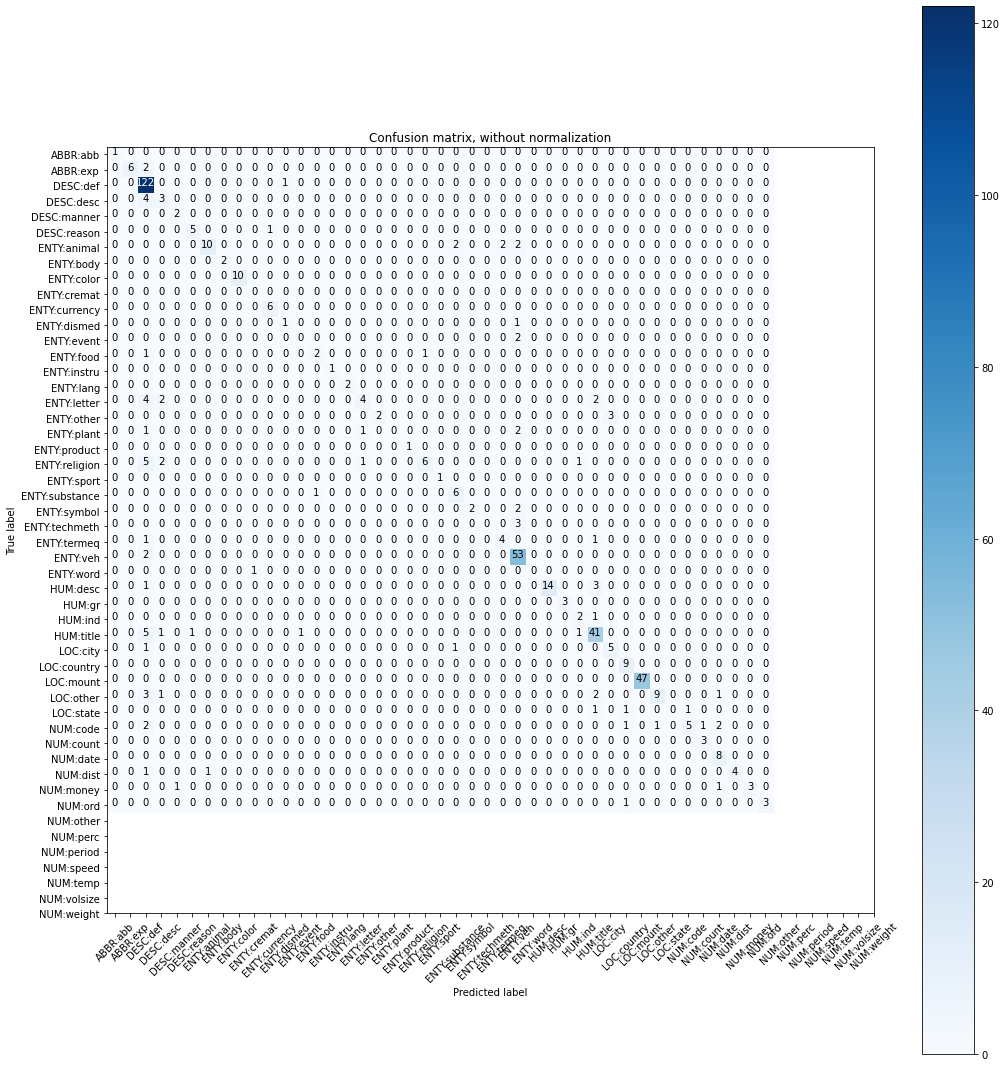

In [39]:
cnf_matrix = confusion_matrix(test['fine_category'], preds_fine)
np.set_printoptions(precision=2)
plt.rcParams["figure.figsize"] = (15,15)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(le_fine.classes_),normalize=False,
                      title='Confusion matrix, without normalization')

In [117]:
def predict(config):
    '''
    AIM: to predict the class label of the question
    INPUT: question to predict as a dict 
    OUTPUT: required class label of the question to predict
    '''
    if type(config) == dict:
        question = config['text']
        #class_label = config['class']
        
    text = [question]
    processed = preprocess(text, keep_list = common_dot_words, remove_stopwords = True)
    ques_features = get_nlp_features(processed)
    feature_vecs = vectorize_features(count_vecs, ques_features)
    feature_vecs = wrangle_features(feature_vecs)
    pred = [model_coarse.predict(feature_vecs), model_fine.predict(feature_vecs)]
    
    return [le_coarse.inverse_transform(pred[0])[0], le_fine.inverse_transform(pred[1])[0]]


In [130]:
predict({"text": "What is Australia 's national flower ?"})

/Users/adityanannapaneni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()


['ENTY', 'ENTY:plant']

In [149]:
# Saving the model

import pickle
with open("model_coarse.bin", 'wb') as f_out:
    pickle.dump(model_coarse, f_out)
    f_out.close()

with open("model_fine.bin", 'wb') as f_out:
    pickle.dump(model_fine, f_out)
    f_out.close()


In [150]:
##loading the model from the saved file
with open('model_fine.bin', 'rb') as f_in:
    model_fine = pickle.load(f_in)

print(predict({'text':'What is cholesterol ?'}))

['DESC', 'DESC:def']


/Users/adityanannapaneni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()


In [76]:
# Saving the count vecs

import pickle
with open("count_vecs", 'wb') as f_out:
    pickle.dump(count_vecs, f_out)
    f_out.close()

In [77]:
# saving label encoders

import pickle
with open("le_coarse", 'wb') as f_out:
    pickle.dump(le_coarse, f_out)
    f_out.close()

with open("le_fine", 'wb') as f_out:
    pickle.dump(le_fine, f_out)
    f_out.close()
